## Multilingual Model Approach

Rather than treating each language independently, a multilingual model is *pre-trained* on text coming from a mix of languages! 

We'll be playing with a specific multilingual model named  **XLM-R** from Facebook (short for "Cross-Lingual Language Model - Roberta"). 

While the original BERT was pre-trained on English Wikipedia and BooksCorpus (a collection of self-published books) XLM-R was pre-trained on Wikipedia and Common Crawl data from **100 different languages**! Not 100 different models trained on 100 different languages, but a *single* BERT-type model that was pre-trained on all of this text together.

There really isn't anything here that's trying to deliberately differentiate between languages. For example, in XLM-R:
* There is a single, shared vocabulary (with 250k tokens) to cover all 100 languages. 
* There is no special marker added to the input text to indicate what language it is.
* It wasn't trained with "parallel data" (the same sentence in multiple languages).
* We haven't modified the training objective to encourage it to learn how to translate. 

And yet, instead of predicting nonsense or having only the barest understanding of any of its many input languages, XLM-R performs surprisingly well, even compared to models trained on a single language! 

## Cross-Lingual Transfer

If your application is in another language (we'll use Arabic as the example from here on out), you can use XLM-R the same way you would regular BERT. You can fine-tune XLM-R on your Arabic training text, and then use it to make predictions in Arabic.

However, XLM-R allows you to leverage another technique that's even more surprising...

Let's say you are trying to build a model to automatically identify nasty (or "toxic") user comments in Arabic. There's already a great dataset out there for this called "Wikipedia Toxic Comments" with roughly 225k labeled comments--except that it's all in English!

What are your options? Gathering a similar-sized dataset in Arabic would have to be costly. Applying Machine Translation in some way could be interesting, but has its limitations (I'll discuss translation more in a later seciton).

XLM-R provides another avenue called "Cross-Lingual Transfer". You can fine-tune XLM-R on the Wikipedia Toxic Comments dataset in English, and then apply it to Arabic comments!

![Cross-Lingual Transfer](https://drive.google.com/uc?id=1bKt1XG7XQj77ZdkSu5-YxtPyjH_7Xk_6)

XLM-R is able to take it's task-specific knowledge that it learned in English and apply it to Arabic, even though we never showed it any Arabic examples! It's the concept of transfer learning applied from one language to another--thus, "Cross-Lingual Transfer".

In the Notebook, we'll see that training XLM-R purely on ~400k *English* samples actually yields *better* results than fine-tuning a "monolingual" Arabic model on (a much smaller) Arabic dataset.

**Alternative approach - Augment Training Data** 

If there already exists a large amount of labeled *English* text for your task, then you could translate this labeled text into Arabic and use it to augment your available *Arabic* training data.

![Augment training data](https://drive.google.com/uc?id=1bKJ_xtWQ2bXzpSGiL94kuISfCRVJz0Mj)

If there is a decent monolingual model available in your language, and there is a large English dataset available for your task, then this is a great technique. We applied this technique to Arabic in one of our accompanying Notebooks and it outperformed XLM-R (at least in our initial results--we didn't perform a rigorous benchmark).

## Natural Language Inferencing

The most commonly used task for evaluating multilingual models is called  **Natural Language Inferencing (NLI)**. The reason for this is that there is an excellent multilingual benchmark dataset available called **XNLI**. 

In NLI, we are given two sentences: (1) a "premise" and (2) a "hypothesis" and asked to determine whether:
* 2 follows logically from 1 (This is called "**entailment**")
* 2 contradicts 1 ("contradiction")
* 2 has no effect on 1 ("neutral") 

|  Premise |  Label | Hypothesis  |
|---|---|---|
| The man inspects his uniform.  |  Contradiction |  The man is sleeping. |
| An older and younger man smiling.  | Neutral  | Two men are smiling and laughing at the cats.  |
| A soccer game with multiple males playing.  | Entailment  | Some men are playing a sport.  |

## MNLI and XNLI

Benchmarking multilingual models on NLI is done with a combination of two datasets named "MNLI" and "XNLI".

MNLI will provide us with a large number of **English** training examples to fine-tune XLM-Roberta on the general task of NLI. 

XNLI will provide us with a small number of NLI test examples *in different languages*. We're going to take our XLM-Roberta model (which we'll fine-tune only on the English MNLI examples) and apply it to the **Arabic** test cases from XNLI. 

## Overview of XLM-R Tokenizer

In [1]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 2.1MB 4.1MB/s 
     |████████████████████████████████| 3.3MB 19.0MB/s 
     |████████████████████████████████| 901kB 43.2MB/s 
     |████████████████████████████████| 1.2MB 4.1MB/s 


In [2]:
import os
import csv
import nltk
import time
import torch
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import XLMRobertaTokenizer, BertTokenizer, XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [3]:
# Download the tokenizer for the XLM-Robert `base` model.
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base" )

# Retrieve the full list of tokens.
all_tokens = list(tokenizer.get_vocab().keys())
print(f'The vocabulary contains {len(all_tokens):,} tokens.')



The vocabulary contains 250,002 tokens.


## SentencePiece vs WordPiece

XLM-R uses a SentencePiece model, which is a little different than BERT's WordPiece model.

We can tokenize an example sentence and compare the tokens.

In [4]:
# Download the tokenizer for the XLM-Robert `base` model.
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

example_sentence = 'The XLM-R model has many word embeddings.'

# Tokenize with SentencePiece
xlmr_tokens = tokenizer.tokenize(example_sentence)

# Tokenize with WordPiece
bert_tokens = bert_tokenizer.tokenize(example_sentence)

In [5]:
def print_as_rows(list_a, list_b):
  row_a = ""
  row_b = ""
  while len(list_a) < len(list_b):
    list_a.append("")
  while len(list_b) < len(list_a):
    list_b.append("")
  for i in range(len(list_a)):
    str_a = list_a[i]
    str_b = list_b[i]
    pad_len = max(len(str_a), len(str_b)) + 2
    row_a += f"{str_a:>{pad_len}}"
    row_b += f"{str_b:>{pad_len}}"
  print(row_a)
  print(row_b)

In [6]:
print_as_rows(xlmr_tokens, bert_tokens)

  ▁The  ▁XL     M  -  R  ▁model  ▁has  ▁many  ▁word   ▁   embe   dding    s  .
   The    X  ##LM  -  R   model   has   many   word  em  ##bed  ##ding  ##s  .


As an example, I'll use a misspelling of the word "philosophy": "philosphy". This will cause the tokenizer to break the word into subwords.

In WordPiece, subwords are denoted by two hash characters, except the *first* subword in a word. 

```
 BERT /     WordPiece:  phil  ##os  ##phy
XLM-R / SentencePiece:	▁phil   os    phy
```

In SentencePiece, all spacing is captured.

> Note: The marking character used by SentencePiece looks like an underscore, but it as actually unicode symbol U+2581, named "Lower One Eighth Block". I'll refer to it as an underscore for simplicity, though.
* Underscore: _
* U+2581: ▁

With SentencePiece, you can interpret the underscore as a space, because that's exactly what it represents! 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Maximum token length: 16 




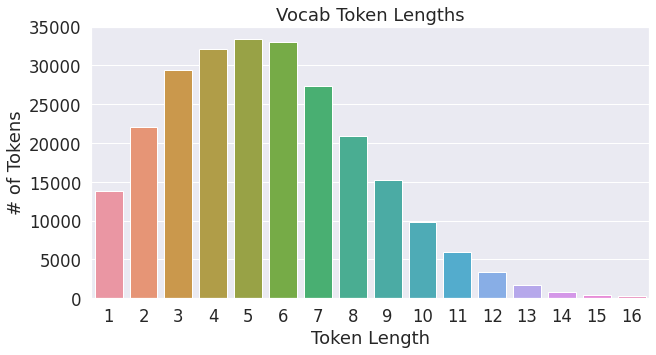

In [7]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Measure the length of every token in the vocab.
token_lengths = [len(token) for token in all_tokens]

# Plot the number of tokens of each length.
sns.countplot(token_lengths)
plt.title('Vocab Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('# of Tokens')

print(f'Maximum token length: {max(token_lengths)} \n\n')

plt.show()

## English Words

In [8]:
nltk.download('wordnet')

english_tokens = []

for token in all_tokens:
  if token[0] == '▁':
    if wordnet.synsets(token[1:]):
      english_tokens.append(token[1:])

print(f"Number of full english words in SentencePiece tokenizer: {len(english_tokens)}. Their percentage: {len(english_tokens)/len(all_tokens)*100:.2f}%")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Number of full english words in SentencePiece tokenizer: 11396. Their percentage: 4.56%


## Dataset

**MNLI**

* 392,000 training examples
* English-ONLY


**XNLI**

* 2,500 validation examples
* 5,000 test examples
* 0 training samples
* Same 7,500 examples are provided in 15 languages (14 + English), all human translated.

The MNLI dataset is large (over 400k samples!), which can make training slow. Because of this, you might choose to take a smaller sample of the dataset so that we can run fine-tuning in a reasonable amount of time.

For MNLI and XNLI, the labels are as follows:
- 0 = entailment
- 1 = neutral
- 2 = contradiction

In [9]:
# Take 10,000 samples
# mnli_dataset = tfds.load(name="multi_nli", split="train[:10000]")

# Take the full dataset.
mnli_dataset = tfds.load(name="multi_nli", split="train")

label_names = ['entailment', 'neutral', 'contradiction']

for example in mnli_dataset.shuffle(buffer_size=256).take(count=3):
    # The fields are Tensors, so we call `numpy` to cast them to
    # basic types, and then `decode` to convert from bytes to strings.
    premise = example['premise'].numpy().decode("utf-8")
    hypothesis = example['hypothesis'].numpy().decode("utf-8")
    label = example['label'].numpy()
    label_name = label_names[label]
    print(f"Premise: {premise}\n")
    print(f"Hypothesis: {hypothesis}\n")
    print(f"Label: {label_name}")
    print("\n----------------------------\n")

INFO:absl:No config specified, defaulting to first: multi_nli/plain_text
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: multi_nli/plain_text/1.0.0
INFO:absl:Load dataset info from /tmp/tmpuqsmr2sxtfds
INFO:absl:Field info.description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset multi_nli (/root/tensorflow_datasets/multi_nli/plain_text/1.0.0)


INFO:absl:Downloading https://cims.nyu.edu/~sbowman/multinli/multinli_1.0.zip into /root/tensorflow_datasets/downloads/cims.nyu.edu_sbowman_multinli_multinli_1.0J8DJPZYOuYTFKvS5PRka8zVckAfRqB9lgZ_pBttik4c.zip.tmp.44dd1869557d49909191d692fac53092...
INFO:absl:Generating split train


Shuffling and writing examples to /root/tensorflow_datasets/multi_nli/plain_text/1.0.0.incomplete72QY4J/multi_nli-train.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/multi_nli/plain_text/1.0.0.incomplete72QY4J/multi_nli-train.tfrecord. Shard lengths: [392702]
INFO:absl:Generating split validation_matched


Shuffling and writing examples to /root/tensorflow_datasets/multi_nli/plain_text/1.0.0.incomplete72QY4J/multi_nli-validation_matched.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/multi_nli/plain_text/1.0.0.incomplete72QY4J/multi_nli-validation_matched.tfrecord. Shard lengths: [9815]
INFO:absl:Generating split validation_mismatched


Shuffling and writing examples to /root/tensorflow_datasets/multi_nli/plain_text/1.0.0.incomplete72QY4J/multi_nli-validation_mismatched.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/multi_nli/plain_text/1.0.0.incomplete72QY4J/multi_nli-validation_mismatched.tfrecord. Shard lengths: [9832]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split train, from /root/tensorflow_datasets/multi_nli/plain_text/1.0.0


Dataset multi_nli downloaded and prepared to /root/tensorflow_datasets/multi_nli/plain_text/1.0.0. Subsequent calls will reuse this data.
Premise: We ask nothing but food and shelter.

Hypothesis: All we're asking for is something to eat and a place to stay.

Label: entailment

----------------------------

Premise: i you know i think people that own homes a lot in North Dallas are very materialistic

Hypothesis: People in North Dallas only care about material goods and nothing else. 

Label: neutral

----------------------------

Premise: In a competitive environment, the Postal Service could easily retain universal service, but perhaps not a universal service standard.

Hypothesis: Universal service standards include consistent delivery times across all offices.

Label: neutral

----------------------------



In each example, the hypothesis sentence following the premise sentence is either entailed, a contradiction, or neutral. 

It's worth noting that many of these examples are ambiguous, and even the human labelers disagreed about some of them--especially in cases where the hypothesis is borderline neutral. Despite that, BERT models still perform very well on this benchmark! 

## XNLI

In [10]:
# Retrieve the test set sentence pairs (contains all 14 languages!)
xnli_dataset = tfds.load(name='xnli', split="test")

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: xnli/1.1.0
INFO:absl:Load dataset info from /tmp/tmp2dijhjl8tfds
INFO:absl:Generating dataset xnli (/root/tensorflow_datasets/xnli/1.1.0)


INFO:absl:Downloading https://cims.nyu.edu/~sbowman/xnli/XNLI-1.0.zip into /root/tensorflow_datasets/downloads/cims.nyu.edu_sbowman_xnli_XNLI-1.03KwEkUmgrwSLRpNWdXc1Nk6sEK1A8TiZrjH6svYOGWc.zip.tmp.08b8ccdb22934b748730aebb4610d025...
INFO:absl:Generating split test


Shuffling and writing examples to /root/tensorflow_datasets/xnli/1.1.0.incomplete41VF32/xnli-test.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/xnli/1.1.0.incomplete41VF32/xnli-test.tfrecord. Shard lengths: [5010]
INFO:absl:Generating split validation


Shuffling and writing examples to /root/tensorflow_datasets/xnli/1.1.0.incomplete41VF32/xnli-validation.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/xnli/1.1.0.incomplete41VF32/xnli-validation.tfrecord. Shard lengths: [2490]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/xnli/1.1.0


Dataset xnli downloaded and prepared to /root/tensorflow_datasets/xnli/1.1.0. Subsequent calls will reuse this data.


To reference a particular language, we'll need it's 2-character code name, as well as its index in the list of XNLI languages.

You can reference the following table to choose different languages. 

| Index | Code | Language   |
|-------|------|------------|
| 0     | ar   | Arabic     |
| 1     | bg   | Bulgarian  |
| 2     | de   | German     |
| 3     | el   | Greek      |
| 4     | en   | English    |
| 5     | es   | Spanish    |
| 6     | fr   | French     |
| 7     | hi   | Hindi      |
| 8     | ru   | Russian    |
| 9     | sw   | Swahili    |
| 10    | th   | Thai       |
| 11    | tr   | Turkish    |
| 12    | ur   | Urdu       |
| 13    | vi   | Vietnamese |
| 14    | zh   | Chinese    |

We'll use Arabic in this Notebook

In [11]:
language_code = 'ar'
language_index = 0

label_names = ['entailment', 'neutral', 'contradiction']

for ex in xnli_dataset.shuffle(buffer_size=256).take(count=3):
  
    # 'ex' is a Python dictionary representing one example, with three fields.
    
    # The fields are Tensors, so we call `numpy` to cast them to
    # basic types, and then `decode` to convert from bytes to strings.
    
    # Retrieve the, e.g., Turkish version of the premise using the language code
    # (e.g., 'tr').
    premise = ex['premise'][language_code].numpy().decode("utf-8")

    # Retrieve the translated version of the hypothesis, using the index of 
    # the language we want. 
    hypothesis = ex['hypothesis']['translation'][language_index].numpy().decode("utf-8")
  
    # Retrieve the label value for this example, and look up the label name.
    label = ex['label'].numpy()
    label_name = label_names[label]

    print(f"Premise: {premise}\n")
    print(f"Hypothesis: {hypothesis}\n")
    print(f"Label name: {label_name}")

    print('\n----------------\n')

Premise: قام بتسوية تلسكوبه على هذا الرقم.

Hypothesis: وجه تلسكوبه على الشكل في الصباح.

Label name: neutral

----------------

Premise: أجاب العديد من الضباط من أجل مساعدة المدنيين الجرحى وحث أولئك الذين يستطيعون المشي لإخلاء المنطقة على الفور.

Hypothesis: في المجموع، رد سبعة وعشرن ضابطًا على الحادث.

Label name: neutral

----------------

Premise: اسمحوا لي أن أقدم الكابتن بلود، يجب على بيرفورس بيشوب أن يكون في أفضل حالاته

Hypothesis: لم بالضرورة الأسقف لم يضع على مظهر قوي.

Label name: contradiction

----------------



In [12]:
sentence_1 = "Hey there reader!"
sentence_2 = "How are you today?"

# Encode the two sentences together.
encoded = tokenizer.encode_plus(sentence_1, sentence_2)

# Print the IDs of the resulting tokens.
print ("Input IDs:      ", encoded['input_ids'])

# Convert the token IDs back to strings so we can check them out.
print ("Tokens:         ", tokenizer.convert_ids_to_tokens(encoded['input_ids']))

# The tokenizer returns an attention mask, which masks out PAD tokens. 
# Since we aren't doing any padding yet, the mask is just all 1s. 
print ("\nAttention Mask: ", encoded['attention_mask'])


Input IDs:       [0, 28240, 2685, 155255, 38, 2, 2, 11249, 621, 398, 18925, 32, 2]
Tokens:          ['<s>', '▁Hey', '▁there', '▁reader', '!', '</s>', '</s>', '▁How', '▁are', '▁you', '▁today', '?', '</s>']

Attention Mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Choose maximum sequence length

In [13]:
lengths_en = []

labels_en = []

print('Tokenizing all examples to check sequence lengths...')

# Iterate through the dataset...
for ex in tqdm(mnli_dataset):

    # Retrieve the premise and hypothesis strings. 
    premise = ex['premise'].numpy().decode("utf-8")
    hypothesis = ex['hypothesis'].numpy().decode("utf-8")
    
    # `tokenizer.encode` will tokenize the sentence, map the tokens to ids, 
    # and add the required special tokens.:
    encoded = tokenizer.encode(
                        premise,
                        hypothesis,
                        add_special_tokens = True,
                   )

    # Record the length.
    lengths_en.append(len(encoded))

    labels_en.append(ex['label'].numpy())

print('DONE.')
print('{:>10,} samples'.format(len(lengths_en)))

  0%|          | 124/392702 [00:00<05:17, 1234.98it/s]

Tokenizing all examples to check sequence lengths...


100%|██████████| 392702/392702 [03:54<00:00, 1676.29it/s]

DONE.
   392,702 samples


Let's plot distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


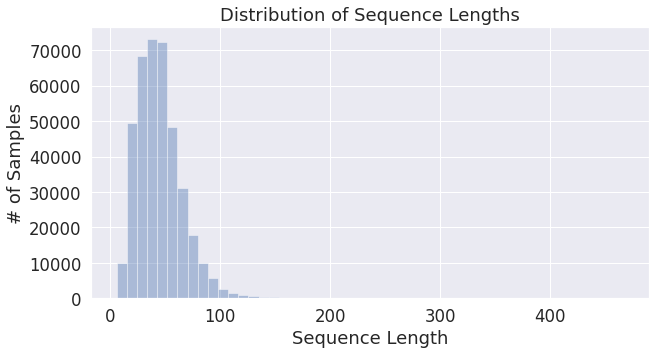

In [14]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(lengths_en, kde=False, rug=False)

plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('# of Samples')

plt.show()

In [15]:
max_len = 128

num_truncated = np.sum(np.greater(lengths_en, max_len))

print(f"Number of truncated examples is {num_truncated} out of {len(lengths_en)}, which is {num_truncated/len(lengths_en):.2%}")

Number of truncated examples is 1680 out of 392702, which is 0.43%


What about class imbalance?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


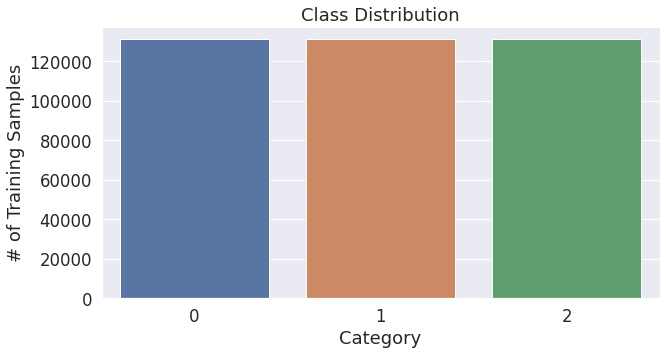

In [16]:
# Plot the number of tokens of each length.
sns.countplot(labels_en)

plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('# of Training Samples')

plt.show()

Looks fine.

## Tokenizing training examples

In [17]:
labels_en = []
input_ids_en = []
attn_masks_en = []

print('Encoding all examples...')

# Iterate through the dataset...
for ex in tqdm(mnli_dataset):

    # Retrieve the premise and hypothesis strings. 
    premise = ex['premise'].numpy().decode("utf-8")
    hypothesis = ex['hypothesis'].numpy().decode("utf-8")

    # Convert sentence pairs to input IDs, with attention masks.
    encoded_dict = tokenizer.encode_plus(premise, hypothesis, 
                                              max_length=max_len, 
                                              padding='max_length',
                                              truncation=True, 
                                              return_tensors='pt')

    # Add this example to our lists.
    input_ids_en.append(encoded_dict['input_ids'])
    attn_masks_en.append(encoded_dict['attention_mask'])
    labels_en.append(ex['label'].numpy())

    # Note that XLM-R does not appear to use Segment IDs! 
    # (The XLMRobertaTokenizer does not return them).
    
# Convert each Python list of Tensors into a 2D Tensor matrix.
input_ids_en = torch.cat(input_ids_en, dim=0)
attn_masks_en = torch.cat(attn_masks_en, dim=0)

# Cast the labels list to a Tensor.
labels_en = torch.tensor(labels_en)

print('   DONE. {:,} examples.'.format(len(labels_en)))

  0%|          | 91/392702 [00:00<07:11, 909.29it/s]

Encoding all examples...


100%|██████████| 392702/392702 [04:19<00:00, 1511.27it/s]


   DONE. 392,702 examples.


## Train-Validation split

In [18]:
dataset = TensorDataset(input_ids_en, attn_masks_en, labels_en)
train_size = int(.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


## DataLoader

In [19]:
# Specify our batch size.
batch_size = 16

# Create the DataLoaders for our training sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Fine-Tune XLM-R on English NLI

We'll fine-tune XLM-R on *English* MNLI. What it learns about NLI from this large *English* training set will carry over to *Arabic*!

In [20]:
xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3)

# Connect to the GPU.
device = torch.device('cuda')

# Report what GPU we were granted.
print('  GPU:', torch.cuda.get_device_name(0))

# Copy the initial model weights to the GPU.
desc = xlmr_model.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

  GPU: Tesla V100-SXM2-16GB


In [21]:
optimizer = AdamW(xlmr_model.parameters(),
                  lr = 5e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

## Helper Function

In [25]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Training Loop

In [26]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    xlmr_model.train()

    # For each batch of training data...
    for step, batch in enumerate(tqdm(train_dataloader)):

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        #
        # Even though this is a two sentence task, XLM-R does not appear to
        # require an explicit "Segment ID" mask.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        xlmr_model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        output = xlmr_model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = output[0]
        logits = output[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(xlmr_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
 
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    xlmr_model.eval()

    # Tracking variables 
    total_eval_loss = 0


    predictions, true_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output = xlmr_model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = output[0]
            logits = output[1]
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences.

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Measure validation accuracy...

    # Combine the results across all batches. 
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # For each sample, pick the label (0, 1, or 2) with the highest score.
    predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

    # Calculate the validation accuracy.
    val_accuracy = (predicted_labels == flat_true_labels).mean()

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  0%|          | 1/22090 [00:00<1:03:39,  5.78it/s]


======== Epoch 1 / 2 ========
Training...


100%|██████████| 22090/22090 [53:48<00:00,  6.84it/s]



  Average training loss: 0.40
  Training epcoh took: 0:53:48

Running Validation...


  0%|          | 1/22090 [00:00<58:14,  6.32it/s]

  Accuracy: 0.82
  Validation Loss: 0.51
  Validation took: 0:01:28

======== Epoch 2 / 2 ========
Training...


100%|██████████| 22090/22090 [53:48<00:00,  6.84it/s]



  Average training loss: 0.45
  Training epcoh took: 0:53:48

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.51
  Validation took: 0:01:28

Training complete!
Total training took 1:50:33 (h:mm:ss)


In [27]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.40,0.51,0.82,0:53:48,0:01:28
2,0.45,0.51,0.82,0:53:48,0:01:28


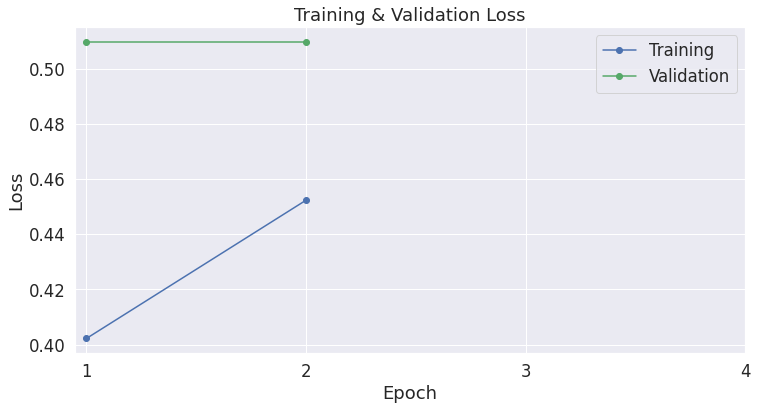

In [28]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Test on Arabic XNLI

Now we can see just how well this "Cross-Lingual Transfer Learning" works. We've only trained on English examples so far, but we're going to test on the Arabic XNLI examples.

## Tokenize Arabic Test Samples

In [29]:
xnli_test_dataset = tfds.load(name='xnli', split="test")

labels_ar = []
input_ids_ar = []
attn_masks_ar = []

print('Encoding test examples...')

# Iterate through the XNLI dataset...
for ex in xnli_test_dataset:

    # Retrieve the premise and hypothesis strings. 
    premise = ex['premise'][language_code].numpy().decode("utf-8")
    hypothesis = ex['hypothesis']['translation'][language_index].numpy().decode("utf-8")

    # Convert sentence pairs to input IDs, with attention masks.
    encoded_dict = tokenizer.encode_plus(premise, hypothesis, 
                                              max_length=max_len, 
                                              padding='max_length',
                                              truncation=True, 
                                              return_tensors='pt')

    # Add this example to our lists.
    input_ids_ar.append(encoded_dict['input_ids'])
    attn_masks_ar.append(encoded_dict['attention_mask'])
    labels_ar.append(ex['label'].numpy())
    
# Convert each Python list of Tensors into a 2D Tensor matrix.
input_ids_ar = torch.cat(input_ids_ar, dim=0)
attn_masks_ar = torch.cat(attn_masks_ar, dim=0)

# Cast the labels list to a Tensor.
labels_ar = torch.tensor(labels_ar)

print('   DONE. {:,} examples.'.format(len(labels_ar)))

INFO:absl:Load dataset info from /root/tensorflow_datasets/xnli/1.1.0
INFO:absl:Reusing dataset xnli (/root/tensorflow_datasets/xnli/1.1.0)
INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/xnli/1.1.0


Encoding test examples...
   DONE. 5,010 examples.


In [30]:
# Construct a TensorDataset from the encoded examples.
prediction_dataset = TensorDataset(input_ids_ar, attn_masks_ar, labels_ar)

# And a dataloader for handling batching.
prediction_dataloader = DataLoader(prediction_dataset, batch_size=batch_size)

## Predictions

In [31]:
# Prediction on test set
print('Predicting labels for {:,} test examples...'.format(len(input_ids_ar)))

# Put model in evaluation mode
xlmr_model.eval()

# Tracking variables 
predictions , true_labels = [], []

count = 0

# Predict 
for batch in prediction_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = xlmr_model(b_input_ids, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 5,010 test examples...
    DONE.


To turn our model outputs into actual predictions, we need to:

1. Re-combine the predictions from across all of the batches.
2. Pick a class label for each prediction by choosing the class with the highest output value.

In [32]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# For each sample, pick the label (0, 1, or 2) with the highest score.
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

In [33]:
# Tally the number of correct predictions to get our accuracy.
accuracy = (predicted_labels == flat_true_labels).mean()

print('XLM-R Prediction accuracy: {:.3f}'.format(accuracy))

XLM-R Prediction accuracy: 0.709


Random guessing will give us

In [34]:
# Randomly guess labels for all of the test samples.
random_labels = np.random.randint(low=0, high=2, size=(predicted_labels.shape))

# Calculate accuracy.
rand_accuracy = (random_labels == flat_true_labels).mean()

print('Random guessing accuracy: {:.3f}'.format(rand_accuracy))

Random guessing accuracy: 0.347


The authors of XML-RoBERTa reported a score of 0.738 on Arabic in their [paper](https://arxiv.org/pdf/1911.02116.pdf) in Table 1:

![Arabic results](https://drive.google.com/uc?id=1bO0h0_72uRXK3fv4ILb8mPtWZSZz6tXA)

The model in the bottom row of the table is larger--it matches the scale of BERT-large. We are using the smaller 'base' size in this notebook.

Our lower accuracy may have to do with parameter choices like batch size,  learning rate, and overfitting.